In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import datetime
import numpy as np
import scipy.optimize as opt
import shapely.geometry as geom
import ipas.crystals as ipas

# not totally sure what this does but it sounds nice
from shapely import speedups
if speedups.available:
    speedups.enable()

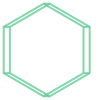

In [2]:
seedcrystal = ipas.IceCrystal(length=4, width=6, rotation=(0,np.pi/2-.1,0))
cluster = ipas.IceCluster([seedcrystal])
cluster.plot()

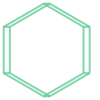

In [3]:
crystal2 = ipas.IceCrystal(length=4, width=6, rotation=(0,np.pi/2+.1,0))
crystal2.plot()

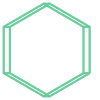

In [4]:
cluster.add_crystal_from_above(crystal2)
# view from the top
cluster.plot()

In [5]:
cluster.write_obj('cluster.obj')

In [7]:
cluster.crystals[0].points

array([( 2.78476349, -1.5, -1.73063351), ( 2.78476349,  1.5, -1.73063351),
       ( 0.19966683,  3. , -1.99000833), (-2.38542982,  1.5, -2.24938316),
       (-2.38542982, -1.5, -2.24938316), ( 0.19966683, -3. , -1.99000833),
       ( 2.38542982, -1.5,  2.24938316), ( 2.38542982,  1.5,  2.24938316),
       (-0.19966683,  3. ,  1.99000833), (-2.78476349,  1.5,  1.73063351),
       (-2.78476349, -1.5,  1.73063351), (-0.19966683, -3. ,  1.99000833)], 
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8')])

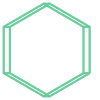

In [6]:
# view from the top
cluster.rotate([0,0,0])
cluster.plot()

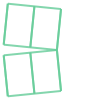

In [6]:
# view from the side
cluster.rotate([np.pi/2,0,0])
cluster.plot()

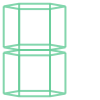

In [7]:
# view from the other side
cluster.rotate([np.pi/2,np.pi/2,0])
cluster.plot()

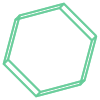

In [8]:
cluster.rotate([0,0,np.pi/4])
cluster.plot()

## Running a simulation similar to IPAS:

In [2]:
# get the time
start_time = datetime.datetime.now()

# set parameters
cl = 3
cw = 6
nclusters = 1
ncrystals = 300
rand_rotations = 1

# get optimal y rotation for single crystals
f = lambda x: -ipas.IceCrystal(length=cl, width=cw, rotation=[0,x,0]).projectxy().area
yrot = opt.minimize_scalar(f, bounds=(0, np.pi/2), method='Bounded').x

clusters = []
for n in range(nclusters):
    # create cluster
    seedcrystal = ipas.IceCrystal(length=cl, width=cw, rotation=[0, yrot, random.uniform(0, 2*np.pi)])
    cluster = ipas.IceCluster([seedcrystal])
    # add new crystals
    nmisses = 0
    while len(cluster.crystals) < ncrystals:
        zrot = random.uniform(0, 2*np.pi) # randomly choose the rotation around the z-axis
        new_crystal = ipas.IceCrystal(length=cl, width=cw, center=[0, 0, 0], rotation=[0, yrot, zrot])
        crystal_hit = cluster.add_crystal_from_above(new_crystal) # returns false if the crystal misses
        if crystal_hit:
            # recenter the cluster around the center of mass
            cluster.move([ -x for x in cluster.center_of_mass() ])
            for i in range(rand_rotations):
                cluster.rotate([random.uniform(0, 2*np.pi), random.uniform(0, 2*np.pi), 0])
        else:
            nmisses += 1
            if nmisses > 100:
                break # just in case something goes terribly wrong
    clusters.append(cluster)
    
# record the runtime
end_time = datetime.datetime.now()
runtime = end_time - start_time
minutes, seconds = divmod(runtime.total_seconds(), 60)
'Simulation took %d minutes and %.2f seconds' % (minutes, seconds)

'Simulation took 0 minutes and 17.63 seconds'

In [3]:
clusters[0].write_obj('large_cluster.obj')

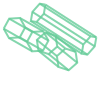

In [27]:
clusters[1].plot()

## Check out the results:

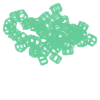

In [11]:
# top view (xy plane)
cluster.rotate([0,0,0])
cluster.plot()

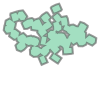

In [12]:
cluster.projectxy()

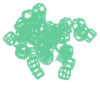

In [15]:
# side view (xz plane)
cluster.rotate([np.pi/2,0,0])
cluster.plot()

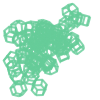

In [17]:
# other side view (yz plane)
cluster.rotate([np.pi/2,np.pi/2, 0])
cluster.plot()

## Try our hand at some optimization:

In [18]:
%timeit cluster.rotate([np.pi/2,np.pi/2,0]) # pretty sure I can improve on this

7.36 ms ± 57.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit cluster.crystals[0].min_vert_dist(new_crystal) # this'll be a bit harder

2.68 ms ± 23.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


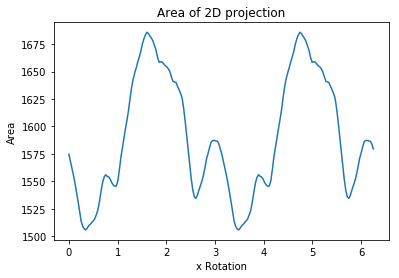

In [39]:
# area wrt the x-axis rotation has a period of pi
xs = np.array(range(200)) * np.pi / 100 # x values ranging from zero to pi
def fx(x):
    cluster.rotate([x, 0, 0])
    return cluster.projectxy().area
areas = [ fx(x) for x in xs ]

plt.plot(xs, areas)
plt.title('Area of 2D projection')
plt.ylabel('Area')
plt.xlabel('x Rotation')

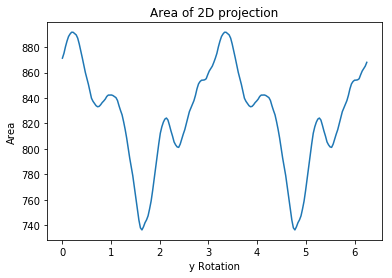

In [22]:
# area wrt the y-axis rotation also has a period of pi
def fy(y):
    cluster.rotate([0, y, 0])
    return cluster.projectxy().area
areas = [ fy(x) for x in xs ]

plt.plot(xs, areas)
plt.title('Area of 2D projection')
plt.ylabel('Area')
plt.xlabel('y Rotation')

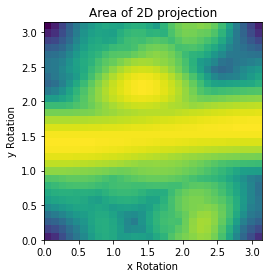

In [15]:
# can I do a 2d version of that graph? tomorrow ...
nsteps = 30
maxrot = np.pi
xs = np.array(range(nsteps)) * maxrot / nsteps
areas = np.empty((nsteps, nsteps))
for i, xrot in enumerate(xs):
    for j, yrot in enumerate(xs):
        cluster.rotate([xrot, yrot, 0])
        areas[i,j] = cluster.projectxy().area
plt.imshow(areas.transpose(), extent=(0, maxrot, 0, maxrot))
plt.title('Area of 2D projection')
plt.ylabel('y Rotation')
plt.xlabel('x Rotation')
# whoa!

In [42]:
# does basin-hopping work? we will find out soon...
def f(x):
    cluster.rotate([x[0], x[1], 0])
    return -cluster.projectxy().area

min_kwargs = {'bounds': [(0, np.pi), (0, np.pi)]}
opt_rot = opt.basinhopping(f, x0=[np.pi/2, np.pi/2], niter=10, T=np.pi/4, minimizer_kwargs=min_kwargs)
opt_rot

                        fun: -1686.2554116740419
 lowest_optimization_result:       fun: -1686.2554116740419
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.54747351e-05,   1.13686838e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 9
   status: 0
  success: True
        x: array([ 1.59966182,  3.11571634])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 543
                        nit: 10
                          x: array([ 1.59966182,  3.11571634])

In [43]:
cluster.rotate([opt_rot.x[0], opt_rot.x[1], 0])
cluster.projectxy().area

1686.2554116740432

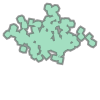

In [44]:
cluster.projectxy()